In [27]:
# Runtime patch: avoid threadpoolctl/OpenBLAS introspection crash on macOS.
import contextlib

class _DummyTPL(contextlib.AbstractContextManager):
    def __init__(self, *args, **kwargs):
        pass
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc, tb):
        return False

def _no_threadpool_limits(*args, **kwargs):
    return _DummyTPL()

try:
    import sklearn.utils.fixes as _fixes
    _fixes.threadpool_limits = _no_threadpool_limits
except Exception:
    pass

try:
    import sklearn.cluster._kmeans as _sk_kmeans
    _sk_kmeans.threadpool_limits = _no_threadpool_limits
except Exception:
    pass

try:
    import threadpoolctl
    threadpoolctl.threadpool_limits = _no_threadpool_limits
except Exception:
    pass

try:
    from threadpoolctl import _OpenBLASModule
    def _safe_get_version(self):
        cfg_fn = getattr(self._dynlib, "openblas_get_config", lambda: None)
        cfg = cfg_fn()
        if not cfg:
            return "unknown"
        try:
            cfg_parts = cfg.split()
            if cfg_parts and cfg_parts[0] == b"OpenBLAS":
                return cfg_parts[1].decode("utf-8")
        except Exception:
            return "unknown"
        return "unknown"
    _OpenBLASModule.get_version = _safe_get_version
except Exception:
    pass


In [28]:
# Ensure folium is available in this kernel.
import importlib
import subprocess
import sys

try:
    import folium  # noqa: F401
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "folium"])
    importlib.invalidate_caches()
    import folium  # noqa: F401


In [29]:
"""
OptimAI – Enterprise Sales Force & Omnichannel Automation Pipeline
-----------------------------------------------------------------
Author: dnAI Javier Castro (July 2025)

Highlights:
- Barcelona-like synthetic geography with configurable polygon/land masks.
- Gradient boosting churn/potential models plus Isolation Forest anomaly guardrails.
- Quantile segmentation + omnichannel NBA scoring (field + CC + ecommerce).
- Channel allocator balancing preferences, digital engagement, and SLA capacity.
- Preparation script builder for each visit/call aligned to NBA rationale.
- Field routing with greedy NBA-aware TSP + optional Folium visualisations.
- Contact-centre scheduler with SLA/backlog summary and monitoring telemetry.
- Enterprise-grade quality gates, logging, and monitoring hooks.
"""

from __future__ import annotations

import logging
import textwrap
from dataclasses import dataclass, field, replace
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Any

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, IsolationForest
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics import roc_auc_score, mean_squared_error, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
try:
    import folium
    from folium.plugins import AntPath, Fullscreen, MousePosition, MeasureControl, BeautifyIcon
    FOLIUM_AVAILABLE = True
except ModuleNotFoundError:
    folium = None
    AntPath = Fullscreen = MousePosition = MeasureControl = BeautifyIcon = None
    FOLIUM_AVAILABLE = False
    logging.warning("Folium not installed; map visualisations disabled. Install with `pip install folium`.")
from IPython.display import display, IFrame, HTML

try:
    from ortools.linear_solver import pywraplp  # noqa: F401
    from ortools.constraint_solver import routing_enums_pb2, pywrapcp  # noqa: F401
except ModuleNotFoundError:
    pywraplp = routing_enums_pb2 = pywrapcp = None
except Exception as exc:  # version mismatches, etc.
    logging.warning("OR-Tools import failed; forcing greedy fallback: %s", exc)
    pywraplp = routing_enums_pb2 = pywrapcp = None

try:
    from shapely.geometry import Point, Polygon
    SHAPELY_AVAILABLE = True
except ModuleNotFoundError:
    SHAPELY_AVAILABLE = False

logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s ▸ %(levelname)s ▸ %(message)s")

FORCE_GREEDY = True
if FORCE_GREEDY:
    pywrapcp = None


# ---------------------------------------------------------------------------
# Configuration & orchestration helpers
# ---------------------------------------------------------------------------
@dataclass
class Config:
    model_dir: Path = Path("models")
    n_territories: int = 20
    n_value_buckets: int = 4
    n_potential_buckets: int = 4
    random_state: int = 42
    nba_lambda_km: float = 5.0
    day_start_min: int = 9 * 60
    avg_speed_kmph: float = 40.0
    service_duration_min: int = 30
    tw_padding_min: int = 60
    gb_classifier_params: Dict[str, Any] = field(default_factory=lambda: {
        "n_estimators": 300, "learning_rate": 0.05, "max_depth": 3})
    gb_regressor_params: Dict[str, Any] = field(default_factory=lambda: {
        "n_estimators": 500, "learning_rate": 0.05, "max_depth": 3})
    channels: Tuple[str, ...] = ("field", "outbound_cc", "inbound_cc", "ecom_assisted", "ecom_self")
    channel_daily_capacity: Dict[str, int] = field(default_factory=lambda: {
        "field": 120,  # aggregated visits across reps
        "outbound_cc": 450,
        "inbound_cc": 350,
        "ecom_assisted": 220,
        "ecom_self": 9999
    })
    channel_sla_minutes: Dict[str, int] = field(default_factory=lambda: {
        "field": 1440,
        "outbound_cc": 240,
        "inbound_cc": 5,
        "ecom_assisted": 60,
        "ecom_self": 0
    })
    script_sections: Tuple[str, ...] = (
        "Context",
        "NBA Rationale",
        "Action Items",
        "Objection Handling",
        "Compliance Reminder"
    )
    prep_script_bullets: int = 4
    max_daily_touchpoints_per_account: int = 2
    kpi_targets: Dict[str, float] = field(default_factory=lambda: {
        "churn_auc": 0.78,
        "potential_rmse": 750.0
    })
    enterprise_checks_enabled: bool = True


@dataclass
class PipelineArtifacts:
    df: pd.DataFrame
    router: Any
    contact_center_schedule: pd.DataFrame
    channel_summary: pd.DataFrame
    channel_tracking: pd.DataFrame
    monitoring: pd.DataFrame
    execution_trace: pd.DataFrame
    validator_issues: List[str]


# ---------------------------------------------------------------------------
# Barcelona geographic helper
# ---------------------------------------------------------------------------
def approx_coast_lon(lat: float) -> float:
    a = (2.36 - 2.16) / (41.7 - 41.2)
    b = 2.16 - a * 41.2
    return a * lat + b - 0.01


BARCELONA_POLY = Polygon([
    (41.20, 1.85), (41.20, 2.14), (41.30, 2.18),
    (41.42, 2.22), (41.55, 2.32), (41.68, 2.30),
    (41.70, 2.15), (41.60, 1.90), (41.40, 1.85)
]) if SHAPELY_AVAILABLE else None


# ---------------------------------------------------------------------------
# Synthetic data generation
# ---------------------------------------------------------------------------
def generate_dummy_customers(
    n_customers=2500,
    n_reps=20,
    cfg: Optional[Config] = None,
    mode: str = "gaussian",
    land_only: bool = True,
    use_polygon: bool = False
) -> pd.DataFrame:
    cfg = cfg or Config()
    rng = np.random.default_rng(cfg.random_state)

    if mode == "uniform":
        lat = rng.uniform(41.2, 41.7, n_customers * 2)
        lon = rng.uniform(1.8, 2.4, n_customers * 2)
    else:
        centers = np.array([
            [41.385, 2.173], [41.448, 2.208], [41.519, 2.199],
            [41.617, 2.287], [41.360, 2.100], [41.480, 2.082],
            [41.565, 2.022], [41.610, 1.855], [41.300, 2.000],
            [41.400, 1.950]
        ])
        chosen = rng.choice(len(centers), size=n_customers * 3, replace=True)
        lat = centers[chosen, 0] + rng.normal(0, 0.025, chosen.size)
        lon = centers[chosen, 1] + rng.normal(0, 0.03, chosen.size)

    if land_only:
        keep = lon <= np.vectorize(approx_coast_lon)(lat)
        lat, lon = lat[keep], lon[keep]

    if land_only and use_polygon and SHAPELY_AVAILABLE:
        mask_poly = [Point(la, lo).within(BARCELONA_POLY) for la, lo in zip(lat, lon)]
        lat, lon = lat[mask_poly], lon[mask_poly]

    if len(lat) < n_customers:
        logging.warning("Only %d candidates after filtering; trimming.", len(lat))
        n_customers = len(lat)
    lat, lon = lat[:n_customers], lon[:n_customers]

    industries = ["Retail", "Healthcare", "SaaS", "Education", "Manufacturing"]
    tiers = list("ABC") + ["Strategic"]
    products = ["CX Suite", "Payments", "Connectivity", "MarTech", "POS"]

    df = pd.DataFrame({
        "client_id": np.arange(n_customers),
        "last_purchase_date": pd.Timestamp.today() -
            pd.to_timedelta(rng.integers(1, 365, n_customers), unit="D"),
        "invoice_id": np.arange(n_customers),
        "amount": rng.uniform(100, 1000, n_customers),
        "churn_label": rng.integers(0, 2, n_customers),
        "future_spend": rng.uniform(500, 4000, n_customers),
        "lat": lat,
        "lon": lon,
        "rep_id": rng.integers(0, n_reps, n_customers),
        "preferred_channel": rng.choice(cfg.channels, n_customers),
        "digital_engagement_score": rng.uniform(0, 100, n_customers),
        "inbound_calls_30d": rng.poisson(1.5, n_customers),
        "outbound_connect_rate": rng.uniform(0.1, 0.9, n_customers),
        "web_sessions_30d": rng.poisson(10, n_customers),
        "abandoned_carts_30d": rng.poisson(1.0, n_customers),
        "orders_ecom_30d": rng.poisson(2.5, n_customers),
        "support_tickets_90d": rng.poisson(0.8, n_customers),
        "csat_score": np.clip(rng.normal(7.5, 1.2, n_customers), 0, 10),
        "recent_issue_flag": rng.choice([0, 1], n_customers, p=[0.8, 0.2]),
        "account_tier": rng.choice(tiers, n_customers, p=[0.35, 0.35, 0.2, 0.1]),
        "industry": rng.choice(industries, n_customers),
        "company_size": rng.integers(20, 2000, n_customers),
        "lifetime_value": rng.gamma(5, 800, n_customers),
        "last_contact_channel": rng.choice(cfg.channels, n_customers),
        "touches_last_30d": rng.poisson(1.5, n_customers),
        "product_interest": rng.choice(products, n_customers)
    })

    na_mask = rng.random(n_customers) < 0.02
    df.loc[na_mask, "amount"] = np.nan
    return df


def generate_rep_homes(df: pd.DataFrame, cfg: Optional[Config] = None) -> pd.DataFrame:
    cfg = cfg or Config()
    rng = np.random.default_rng(cfg.random_state + 123)
    reps = sorted(df.rep_id.unique())
    sample_idx = rng.choice(df.index, size=len(reps), replace=False)
    return pd.DataFrame({
        "rep_id": reps,
        "rep_home_lat": df.loc[sample_idx, "lat"].values,
        "rep_home_lon": df.loc[sample_idx, "lon"].values
    })


# ---------------------------------------------------------------------------
# Quality gates & monitoring
# ---------------------------------------------------------------------------
class DataValidator:
    def __init__(self, required_cols: List[str]):
        self.required_cols = required_cols

    def run(self, df: pd.DataFrame) -> List[str]:
        issues: List[str] = []
        missing = [c for c in self.required_cols if c not in df.columns]
        if missing:
            issues.append(f"Missing columns: {missing}")
        if df.client_id.duplicated().any():
            issues.append("Duplicate client_id detected")
        numeric_cols = df.select_dtypes(include=[np.number])
        if numeric_cols.isnull().any().any():
            issues.append("Numeric columns contain NaN values (pre-imputation)")
        if {"lat", "lon"}.issubset(df.columns):
            if (df["lat"].isnull() | df["lon"].isnull()).any():
                issues.append("Lat/Lon missing values")
        if issues:
            logging.warning("Quality gate raised %d issues", len(issues))
        else:
            logging.info("Quality gate passed")
        return issues


class MonitoringSuite:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.records: List[Dict[str, Any]] = []

    def record(self, metric: str, value: float, details: Optional[str] = None) -> None:
        self.records.append({
            "timestamp": datetime.utcnow(),
            "metric": metric,
            "value": value,
            "target": self.cfg.kpi_targets.get(metric),
            "details": details or ""
        })

    def as_frame(self) -> pd.DataFrame:
        if not self.records:
            return pd.DataFrame(columns=["timestamp", "metric", "value", "target", "details"])
        return pd.DataFrame(self.records)


class ExecutionTracer:
    """Collects lightweight execution events for notebook inspection."""

    def __init__(self):
        self.records: List[Dict[str, Any]] = []

    def log(self, phase: str, message: str, **extra: Any) -> None:
        payload = {"timestamp": datetime.utcnow(), "phase": phase, "message": message}
        payload.update(extra)
        self.records.append(payload)
        logging.info("[%s] %s %s", phase, message, extra if extra else "")

    def as_frame(self) -> pd.DataFrame:
        if not self.records:
            return pd.DataFrame(columns=["timestamp", "phase", "message"])
        return pd.DataFrame(self.records)


# ---------------------------------------------------------------------------
# Predictive models & scoring
# ---------------------------------------------------------------------------
class PredictiveModels:
    def __init__(self, cfg: Config, monitor: Optional[MonitoringSuite] = None):
        self.cfg = cfg
        self.monitor = monitor
        self.churn_model = GradientBoostingClassifier(**cfg.gb_classifier_params,
                                                      random_state=cfg.random_state)
        self.potential_model = GradientBoostingRegressor(**cfg.gb_regressor_params,
                                                         random_state=cfg.random_state)
        self.churn_features_: List[str] = []
        self.potential_features_: List[str] = []
        self.imputer_ = SimpleImputer(strategy="median")

    def _num(self, df: pd.DataFrame) -> pd.DataFrame:
        return df.select_dtypes(include=[np.number])

    def _prep_Xy(self, df: pd.DataFrame, target: str, drop_cols: List[str]) -> Tuple[pd.DataFrame, pd.Series]:
        num = self._num(df)
        X = num.drop(columns=drop_cols, errors="ignore")
        y = num[target]
        return X, y

    def train_churn(self, df: pd.DataFrame) -> float:
        X, y = self._prep_Xy(df, "churn_label",
                             ["client_id", "churn_label", "future_spend"])
        self.churn_features_ = X.columns.tolist()
        X_imp = pd.DataFrame(self.imputer_.fit_transform(X), columns=X.columns)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_imp, y, test_size=0.2, random_state=self.cfg.random_state)
        self.churn_model.fit(X_tr, y_tr)
        auc = roc_auc_score(y_val, self.churn_model.predict_proba(X_val)[:, 1])
        if self.monitor:
            self.monitor.record("churn_auc", auc)
        logging.info("Churn model AUC = %.3f", auc)
        return auc

    def train_potential(self, df: pd.DataFrame) -> float:
        X, y = self._prep_Xy(df, "future_spend",
                             ["client_id", "future_spend", "churn_label"])
        self.potential_features_ = X.columns.tolist()
        X_imp = pd.DataFrame(self.imputer_.fit_transform(X), columns=X.columns)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_imp, y, test_size=0.2, random_state=self.cfg.random_state)
        self.potential_model.fit(X_tr, y_tr)
        rmse = mean_squared_error(y_val, self.potential_model.predict(X_val), squared=False)
        if self.monitor:
            self.monitor.record("potential_rmse", rmse)
        logging.info("Potential model RMSE = %.2f", rmse)
        return rmse

    def predict(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        Xc = df[self.churn_features_]
        Xc_imp = pd.DataFrame(self.imputer_.transform(Xc), columns=Xc.columns)
        df["churn_prob"] = self.churn_model.predict_proba(Xc_imp)[:, 1]

        Xp = df[self.potential_features_]
        Xp_imp = pd.DataFrame(self.imputer_.transform(Xp), columns=Xp.columns)
        df["predicted_potential"] = self.potential_model.predict(Xp_imp)
        return df


class Segmentation:
    def __init__(self, cfg: Config):
        self.cfg = cfg

    def segment(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        if "monetary_6m" not in df.columns:
            df["monetary_6m"] = df.groupby("client_id")["amount"].transform("sum")
        df["value_bucket"] = pd.qcut(df["monetary_6m"],
                                      self.cfg.n_value_buckets,
                                      labels=False, duplicates="drop")
        df["potential_bucket"] = pd.qcut(df["predicted_potential"],
                                          self.cfg.n_potential_buckets,
                                          labels=False, duplicates="drop")
        df["segment"] = df["value_bucket"].astype(str) + df["potential_bucket"].astype(str)
        return df


class NextBestAction:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.weights = {
            "segment": 0.10,
            "churn_prob": 0.30,
            "recency_days": 0.10,
            "predicted_potential": 0.30,
            "digital_engagement_score": 0.10,
            "support_tickets_90d": 0.10
        }

    def _ensure_recency(self, df: pd.DataFrame) -> pd.DataFrame:
        if "recency_days" not in df.columns and "last_purchase_date" in df.columns:
            df = df.copy()
            df["recency_days"] = (pd.Timestamp.today() - pd.to_datetime(df["last_purchase_date"])).dt.days
        elif "recency_days" not in df.columns:
            df["recency_days"] = 0
        return df

    def score(self, df: pd.DataFrame) -> pd.DataFrame:
        df = self._ensure_recency(df).copy()
        z_cols = ["churn_prob", "recency_days", "predicted_potential",
                  "digital_engagement_score", "support_tickets_90d"]
        for col in z_cols:
            df[f"{col}_z"] = StandardScaler().fit_transform(df[[col]])
        df["segment_int"] = df["segment"].astype(int)
        df["segment_z"] = StandardScaler().fit_transform(df[["segment_int"]])
        df["nba_score"] = (
            self.weights["segment"] * df["segment_z"] +
            self.weights["churn_prob"] * df["churn_prob_z"] +
            self.weights["recency_days"] * df["recency_days_z"] +
            self.weights["predicted_potential"] * df["predicted_potential_z"] +
            self.weights["digital_engagement_score"] * df["digital_engagement_score_z"] +
            self.weights["support_tickets_90d"] * df["support_tickets_90d_z"]
        )
        return df


# ---------------------------------------------------------------------------
# Territory design & anomaly detection
# ---------------------------------------------------------------------------
class TerritoryDesign:
    def __init__(self, cfg: Config):
        self.cfg = cfg

    def cluster(self, df: pd.DataFrame) -> pd.DataFrame:
        km = KMeans(n_clusters=self.cfg.n_territories, random_state=self.cfg.random_state)
        df = df.copy()
        df["territory_cluster"] = km.fit_predict(df[["lat", "lon"]].to_numpy())
        self.kmeans = km
        return df

    def match_reps_to_centroids(self, rep_homes: pd.DataFrame) -> pd.DataFrame:
        homes = rep_homes[["rep_home_lat", "rep_home_lon"]].to_numpy()
        cents = self.kmeans.cluster_centers_
        rad = haversine_distances(np.radians(homes), np.radians(cents))
        cost = rad * 6371.0
        row_ind, col_ind = linear_sum_assignment(cost)
        return pd.DataFrame({
            "rep_id": rep_homes["rep_id"].values[row_ind],
            "territory_cluster": col_ind,
            "distance_km": cost[row_ind, col_ind]
        })


def get_territory_customers(df: pd.DataFrame, rep_id: int) -> pd.DataFrame:
    rep_territory = df.loc[df.rep_id == rep_id, "rep_territory"].iloc[0]
    return df[df.territory_cluster == rep_territory]


class AnomalyDetection:
    def __init__(self, features: List[str], contamination=0.02, random_state=42):
        self.features = features
        self.model = IsolationForest(contamination=contamination,
                                     random_state=random_state)

    def fit_predict(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        X = df[self.features].to_numpy()
        self.model.fit(X)
        scores = -self.model.decision_function(X)
        df["anomaly_score"] = scores
        df["is_anomaly"] = self.model.predict(X) == -1
        return df


# ---------------------------------------------------------------------------
# Channel allocator & prep scripts
# ---------------------------------------------------------------------------
class ChannelAllocator:
    def __init__(self, cfg: Config):
        self.cfg = cfg

    @staticmethod
    def _norm(series: pd.Series) -> pd.Series:
        return (series - series.min()) / (series.max() - series.min() + 1e-9)

    def assign(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df["field_score"] = (
            0.45 * self._norm(df["predicted_potential"]) +
            0.30 * self._norm(df["nba_score"]) +
            0.25 * (1 - self._norm(df["digital_engagement_score"]))
        )
        df["outbound_cc_score"] = (
            0.35 * self._norm(df["nba_score"]) +
            0.35 * self._norm(df["churn_prob"]) +
            0.30 * self._norm(1 + df["touches_last_30d"]) * df["outbound_connect_rate"]
        )
        df["inbound_cc_score"] = (
            0.5 * self._norm(df["inbound_calls_30d"]) +
            0.3 * self._norm(df["support_tickets_90d"]) +
            0.2 * self._norm(df["recent_issue_flag"] + 1)
        )
        df["ecom_assisted_score"] = (
            0.4 * self._norm(df["digital_engagement_score"]) +
            0.3 * self._norm(df["abandoned_carts_30d"] + 1) +
            0.3 * self._norm(df["orders_ecom_30d"] + 1)
        )
        df["ecom_self_score"] = (
            0.6 * self._norm(df["digital_engagement_score"]) +
            0.4 * self._norm(df["web_sessions_30d"] + 1)
        )

        for channel in self.cfg.channels:
            pref_mask = df["preferred_channel"] == channel
            df.loc[pref_mask, f"{channel}_score"] *= 1.1

        score_cols = [f"{c}_score" for c in self.cfg.channels]
        score_matrix = df[score_cols].to_numpy()
        max_idx = score_matrix.argmax(axis=1)
        df["recommended_channel"] = np.array(self.cfg.channels)[max_idx]
        df["channel_confidence"] = score_matrix[np.arange(len(df)), max_idx]
        df["channel_reason"] = (
            "Prefers " + df["preferred_channel"] +
            ", NBA=" + df["nba_score"].round(2).astype(str) +
            ", churn=" + df["churn_prob"].round(2).astype(str)
        )
        return df


def build_channel_tracking(df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    """Summarise NBA load per channel before scheduling."""
    base_cols = ["channel", "clients", "avg_nba", "avg_churn",
                 "avg_potential", "avg_confidence", "anomalies"]
    if df.empty or "recommended_channel" not in df.columns:
        return pd.DataFrame({
            "channel": list(cfg.channels),
            "clients": 0,
            "avg_nba": 0.0,
            "avg_churn": 0.0,
            "avg_potential": 0.0,
            "avg_confidence": 0.0,
            "anomalies": 0
        })[base_cols]

    summary = (
        df.groupby("recommended_channel")
          .agg(clients=("client_id", "count"),
               avg_nba=("nba_score", "mean"),
               avg_churn=("churn_prob", "mean"),
               avg_potential=("predicted_potential", "mean"),
               avg_confidence=("channel_confidence", "mean"),
               anomalies=("is_anomaly", "sum"))
          .reset_index()
          .rename(columns={"recommended_channel": "channel"})
    )
    summary = summary.set_index("channel").reindex(cfg.channels, fill_value=0).reset_index()
    return summary[base_cols]


class PrepScriptBuilder:
    def __init__(self, cfg: Config):
        self.cfg = cfg

    def _bullets(self, row: pd.Series) -> Dict[str, List[str]]:
        context = [
            f"Account tier {row.account_tier} ({row.industry}) with {row.company_size} FTEs.",
            f"Last touch on {row.last_contact_channel}; {row.touches_last_30d} touches in 30d.",
            f"Lifetime value €{row.lifetime_value:,.0f}; segment {row.segment}."
        ]
        rationale = [
            f"NBA score {row.nba_score:.2f} driven by churn {row.churn_prob:.2f} and potential €{row.predicted_potential:,.0f}.",
            f"Digital engagement {row.digital_engagement_score:.1f} and {row.orders_ecom_30d} ecommerce orders support offer cross-sell {row.product_interest}."
        ]
        action = [
            f"Lead with {row.product_interest} value prop and reference recent spend €{row.amount:,.0f}.",
            f"Confirm readiness for next quarter budget; align on preferred channel {row.recommended_channel}."
        ]
        if row.recent_issue_flag:
            objection = ["Address recent support pain point before upsell."]
        else:
            objection = [f"Probe for hidden blockers and reference CSAT {row.csat_score:.1f}."]
        compliance = [
            "Log consent for data usage and confirm GDPR-compliant recording.",
            f"Respect SLA of {self.cfg.channel_sla_minutes.get(row.recommended_channel,0)} mins for channel response."
        ]
        return {
            "Context": context,
            "NBA Rationale": rationale,
            "Action Items": action,
            "Objection Handling": objection,
            "Compliance Reminder": compliance
        }

    def build_script(self, row: pd.Series) -> str:
        sections = self._bullets(row)
        lines: List[str] = []
        for section in self.cfg.script_sections:
            lines.append(f"{section}:")
            for bullet in sections.get(section, [])[:self.cfg.prep_script_bullets]:
                bullet_fmt = textwrap.fill(f"- {bullet}", width=92, subsequent_indent="  ")
                lines.append(bullet_fmt)
        return "\n".join(lines)

    def create_scripts(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df["prep_script"] = df.apply(self.build_script, axis=1)
        return df


# ---------------------------------------------------------------------------
# Contact center scheduler
# ---------------------------------------------------------------------------
class ContactCenterScheduler:
    def __init__(self, cfg: Config):
        self.cfg = cfg

    def build_daily_plan(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        schedules = []
        summary_rows = []
        for channel in self.cfg.channels:
            channel_df = df[df["recommended_channel"] == channel]
            cap = self.cfg.channel_daily_capacity.get(channel, len(channel_df))
            scheduled = channel_df.sort_values("nba_score", ascending=False).head(cap).copy()
            scheduled["scheduled_channel"] = channel
            scheduled["scheduled_slot"] = [f"{channel}-{i+1}" for i in range(len(scheduled))]
            schedules.append(scheduled)
            backlog = max(len(channel_df) - cap, 0)
            summary_rows.append({
                "channel": channel,
                "demand": len(channel_df),
                "scheduled": len(scheduled),
                "backlog": backlog,
                "sla_minutes": self.cfg.channel_sla_minutes.get(channel, np.nan),
                "sla_met": backlog == 0
            })
        schedule_df = pd.concat(schedules).sort_values("nba_score", ascending=False) if schedules else pd.DataFrame()
        summary_df = pd.DataFrame(summary_rows)
        return schedule_df, summary_df


# ---------------------------------------------------------------------------
# Router (field reps) with NBA reward
# ---------------------------------------------------------------------------
class RouteOptimizer:
    def __init__(self, cfg: Config):
        self.cfg = cfg

    @staticmethod
    def _gc_km(a: np.ndarray, b: np.ndarray) -> float:
        return float(haversine_distances(np.radians(a[None, :]),
                                         np.radians(b[None, :]))[0, 0] * 6371.0)

    def _select_daily_targets(self, df_rep: pd.DataFrame) -> pd.DataFrame:
        terr = df_rep["rep_territory"].iloc[0]
        cand = df_rep[df_rep["territory_cluster"] == terr]
        cand = cand if len(cand) >= 10 else df_rep
        home = cand[["rep_home_lat", "rep_home_lon"]].iloc[0].to_numpy()
        cand = cand.copy()
        cand["dist_home"] = cand[["lat", "lon"]].apply(
            lambda row: self._gc_km(home, row.to_numpy()), axis=1)
        return cand.sort_values(["nba_score", "dist_home"], ascending=[False, True]).head(10)

    def _compute_time_windows(self, day_df: pd.DataFrame, rng: np.random.Generator) -> pd.DataFrame:
        day_df = day_df.copy()
        mid = rng.integers(630, 930, len(day_df))
        half = self.cfg.tw_padding_min
        day_df["tw_start"] = mid - half
        day_df["tw_end"] = mid + half
        return day_df

    def optimise_for_rep(self, df_rep: pd.DataFrame, return_decisions: bool = False
                          ) -> Tuple[List[int], List[int], Optional[List[pd.DataFrame]]]:
        if len(df_rep) == 0:
            return [], [], None

        rng = np.random.default_rng(self.cfg.random_state + int(df_rep.rep_id.iloc[0]))
        day_df = self._select_daily_targets(df_rep)
        day_df = self._compute_time_windows(day_df, rng)

        home = day_df[["rep_home_lat", "rep_home_lon"]].iloc[0].to_numpy()
        pts = np.vstack([home, day_df[["lat", "lon"]].to_numpy()])
        nba = day_df["nba_score"].to_numpy()

        rad = haversine_distances(np.radians(pts), np.radians(pts))
        dist_km = rad * 6371.0
        nba_norm = (nba - nba.min()) / (nba.max() - nba.min() + 1e-9)
        reward_km_vec = self.cfg.nba_lambda_km * nba_norm

        cost = dist_km.copy()
        cost[:, 1:1 + len(nba)] -= reward_km_vec
        cost_int = np.round(cost * 1000).astype(int)

        remaining = list(range(1, len(pts)))
        route, cur = [], 0
        decisions = []
        current_time = self.cfg.day_start_min

        while remaining:
            nxt = min(remaining, key=lambda j: cost_int[cur, j])
            rows = []
            for j in remaining:
                df_idx = day_df.index[j - 1]
                pure = dist_km[cur, j]
                reward = reward_km_vec[j - 1]
                eff = cost_int[cur, j] / 1000.0
                travel_min = pure / self.cfg.avg_speed_kmph * 60.0
                arrive = current_time + travel_min
                tw_s = day_df.loc[df_idx, "tw_start"]
                tw_e = day_df.loc[df_idx, "tw_end"]
                start_service = max(arrive, tw_s)
                finish = start_service + self.cfg.service_duration_min
                feasible = finish <= tw_e
                rows.append({
                    "step": len(route) + 1,
                    "client_id": day_df.loc[df_idx, "client_id"],
                    "pure_dist_km": pure,
                    "reward_km": reward,
                    "effective_cost_km": eff,
                    "arrival_min": arrive,
                    "finish_min": finish,
                    "tw_start": tw_s,
                    "tw_end": tw_e,
                    "feasible": feasible,
                    "chosen_flag": False
                })
            snap = pd.DataFrame(rows).sort_values("effective_cost_km").reset_index(drop=True)
            chosen_client = day_df.index[nxt - 1]
            snap.loc[snap.client_id == day_df.loc[chosen_client, "client_id"], "chosen_flag"] = True
            decisions.append(snap)

            route.append(chosen_client)
            chosen_row = snap[snap["chosen_flag"]].iloc[0]
            current_time = chosen_row["finish_min"]
            remaining.remove(nxt)
            cur = nxt

        if return_decisions:
            for d in decisions:
                display(d.style.format({
                    "pure_dist_km": "{:.2f}",
                    "reward_km": "{:.2f}",
                    "effective_cost_km": "{:.2f}",
                    "arrival_min": "{:.1f}",
                    "finish_min": "{:.1f}"
                }).set_caption(f"Decision before choosing stop #{int(d.step.iloc[0])}"))
        return route, list(day_df.index), (decisions if return_decisions else None)


# ---------------------------------------------------------------------------
# Visualisations
# ---------------------------------------------------------------------------
def viz_segmentation(df: pd.DataFrame):
    plt.figure()
    plt.scatter(df["monetary_6m"], df["predicted_potential"],
                c=df["segment"].astype(int), s=15)
    plt.colorbar(label="Segment")
    plt.title("Value vs Potential")
    plt.xlabel("Monetary 6m"); plt.ylabel("Predicted Potential")
    plt.tight_layout(); plt.show()


def viz_territories(df: pd.DataFrame):
    plt.figure()
    plt.scatter(df["lon"], df["lat"], c=df["territory_cluster"], s=10)
    plt.title("Territory Clusters (KMeans)")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.tight_layout(); plt.show()


def viz_roc(df: pd.DataFrame):
    fpr, tpr, _ = roc_curve(df["churn_label"], df["churn_prob"])
    plt.figure(); plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--", lw=0.5)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("Churn ROC Curve")
    plt.tight_layout(); plt.show()


def viz_nba_hist(df: pd.DataFrame):
    plt.figure()
    plt.hist(df["nba_score"], bins=25)
    plt.title("NBA Score Distribution")
    plt.xlabel("NBA score"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()


def viz_anomalies(df: pd.DataFrame):
    plt.figure(figsize=(6, 4))
    normal = df[~df.is_anomaly]
    anom = df[df.is_anomaly]
    plt.scatter(normal["nba_score"], normal["anomaly_score"], s=15, alpha=0.3, label="Normal")
    plt.scatter(anom["nba_score"], anom["anomaly_score"], s=30, color="red", marker="x", label="Anomaly")
    plt.xlabel("NBA Score"); plt.ylabel("Anomaly Score")
    plt.legend(); plt.tight_layout(); plt.show()


def viz_anomaly_map(df: pd.DataFrame):
    plt.figure(figsize=(6, 4))
    normal = df[~df.is_anomaly]
    anom = df[df.is_anomaly]
    plt.scatter(normal["lon"], normal["lat"], s=10, alpha=0.25, label="Normal")
    plt.scatter(anom["lon"], anom["lat"], s=25, color="red", label="Anomaly")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.title("Geospatial Anomalies")
    plt.legend()
    plt.tight_layout(); plt.show()


def viz_route(df: pd.DataFrame, rep_id: int,
              order: List[int], day_pool: List[int]):
    territory_df = get_territory_customers(df, rep_id)
    home = df.loc[df.rep_id == rep_id, ["rep_home_lat", "rep_home_lon"]].iloc[0]
    home_lat, home_lon = home
    ordered_df = df.loc[order]
    pool_df = df.loc[day_pool]
    lats = [home_lat] + ordered_df["lat"].tolist() + [home_lat]
    lons = [home_lon] + ordered_df["lon"].tolist() + [home_lon]

    plt.figure(figsize=(6, 6))
    plt.scatter(territory_df["lon"], territory_df["lat"],
                s=12, color="#999999", alpha=0.25, label="Territory (all)")
    plt.scatter(pool_df["lon"], pool_df["lat"],
                s=40, color="#1f77b4", alpha=0.7, label="Daily pool (10)")
    plt.plot(lons, lats, "-o", color="#d62728", lw=1.8, ms=6, label="Route")

    plt.scatter(home_lon, home_lat, marker="s", s=110, color="#2ca02c", label="Home")

    for step, idx in enumerate(order, start=1):
        row = df.loc[idx]
        plt.annotate(f"{step}\n{int(row.client_id)}",
                     (row.lon, row.lat),
                     xytext=(4, 4), textcoords="offset points", fontsize=7)

    plt.title(f"Rep {rep_id} – Territory / Pool / Route")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.legend(fontsize=8)
    plt.tight_layout(); plt.show()

    visit_order = (
        df.loc[order, ["client_id", "lat", "lon", "nba_score", "recommended_channel"]]
          .assign(stop=lambda t: np.arange(1, len(t) + 1))
          .loc[:, ["stop", "client_id", "nba_score", "recommended_channel", "lat", "lon"]]
    )
    display(visit_order.style.format({"nba_score": "{:.2f}",
                                      "lat": "{:.4f}", "lon": "{:.4f}"}))


# ---------------------------------------------------------------------------
# Folium map
# ---------------------------------------------------------------------------
def fancy_route_map(df: pd.DataFrame,
                    rep_id: int,
                    order: List[int],
                    day_pool: List[int]) -> folium.Map:

    if not FOLIUM_AVAILABLE:
        logging.warning("Folium not installed; returning None for map. Install with `pip install folium`.")
        return None

    rep_home = df.loc[df.rep_id == rep_id, ["rep_home_lat", "rep_home_lon"]].iloc[0]
    start = (rep_home.rep_home_lat, rep_home.rep_home_lon)
    territory_df = get_territory_customers(df, rep_id)
    pool_df = df.loc[day_pool]
    ordered_df = df.loc[order]

    fmap = folium.Map(location=start, zoom_start=10,
                      width="100%", height="600px",
                      control_scale=True, tiles="Esri.WorldImagery")

    terr_layer = folium.FeatureGroup(name="Territory (all)", show=True)
    for _, r in territory_df.iterrows():
        folium.CircleMarker(
            location=(r.lat, r.lon), radius=3,
            color="#888888", fill=True, fill_opacity=0.25, weight=0
        ).add_to(terr_layer)
    terr_layer.add_to(fmap)

    pool_layer = folium.FeatureGroup(name="Candidate pool (10)", show=True)
    for _, r in pool_df.iterrows():
        folium.CircleMarker(
            location=(r.lat, r.lon), radius=6,
            color="#1f77b4", fill=True, fill_opacity=0.8, weight=1
        ).add_to(pool_layer)
    pool_layer.add_to(fmap)

    route_layer = folium.FeatureGroup(name="Route (ordered)", show=True)
    for step, (_, r) in enumerate(ordered_df.iterrows(), start=1):
        marker = folium.Marker(
            location=(r.lat, r.lon),
            popup=folium.Popup(
                f"<b>Stop {step}</b><br>Client {r.client_id}<br>NBA {r.nba_score:.2f}<br>Channel {r.recommended_channel}",
                max_width=250)
        )
        marker.add_to(route_layer)
        BeautifyIcon(
            icon_shape="marker", number=step, border_color="#d62728",
            background_color="#d62728", text_color="#ffffff"
        ).add_to(marker)
    route_layer.add_to(fmap)

    path_coords = [start] + ordered_df[["lat", "lon"]].values.tolist() + [start]
    AntPath(path_coords, weight=5, color="#FF8C00", dash_array=[10, 20]).add_to(fmap)

    folium.Marker(location=start,
                  popup=f"<b>Rep {rep_id} Home</b>",
                  icon=folium.Icon(color="green", icon="home", prefix="fa")).add_to(fmap)

    MousePosition(position="bottomright", separator=" , ", prefix="Lat/Lon").add_to(fmap)
    MeasureControl(position="topleft", primary_length_unit="kilometers").add_to(fmap)
    Fullscreen().add_to(fmap)
    folium.LayerControl(collapsed=False).add_to(fmap)
    return fmap


# ---------------------------------------------------------------------------
# Route comparison map (NBA vs distance-only)
# ---------------------------------------------------------------------------
def compare_route_map(df: pd.DataFrame,
                      rep_id: int,
                      nba_order: List[int],
                      dist_order: List[int],
                      day_pool: List[int]) -> folium.Map:

    if not FOLIUM_AVAILABLE:
        logging.warning("Folium not installed; returning None for map. Install with `pip install folium`.")
        return None

    rep_home = df.loc[df.rep_id == rep_id, ["rep_home_lat", "rep_home_lon"]].iloc[0]
    start = (rep_home.rep_home_lat, rep_home.rep_home_lon)
    territory_df = get_territory_customers(df, rep_id)
    pool_df = df.loc[day_pool]
    nba_df = df.loc[nba_order]
    dist_df = df.loc[dist_order]

    fmap = folium.Map(location=start, zoom_start=10,
                      width="100%", height="600px",
                      control_scale=True, tiles="Esri.WorldImagery")

    terr_layer = folium.FeatureGroup(name="Territory (all)", show=True)
    for _, r in territory_df.iterrows():
        folium.CircleMarker(
            location=(r.lat, r.lon), radius=3,
            color="#888888", fill=True, fill_opacity=0.25, weight=0
        ).add_to(terr_layer)
    terr_layer.add_to(fmap)

    pool_layer = folium.FeatureGroup(name="Candidate pool (10)", show=True)
    for _, r in pool_df.iterrows():
        folium.CircleMarker(
            location=(r.lat, r.lon), radius=6,
            color="#1f77b4", fill=True, fill_opacity=0.8, weight=1
        ).add_to(pool_layer)
    pool_layer.add_to(fmap)

    nba_layer = folium.FeatureGroup(name="NBA-aware route", show=True)
    dist_layer = folium.FeatureGroup(name="Distance-only route", show=True)
    dist_rank = {idx: i + 1 for i, idx in enumerate(dist_order)}

    for step, (idx, r) in enumerate(nba_df.iterrows(), start=1):
        dist_stop = dist_rank.get(idx)
        popup_parts = [
            f"<b>NBA stop {step}</b>",
            f"Dist stop {dist_stop}" if dist_stop is not None else None,
            f"Client {int(r.client_id)}",
            f"NBA {r.nba_score:.2f}",
            f"Channel {r.recommended_channel}"
        ]
        popup = "<br>".join([p for p in popup_parts if p is not None])
        marker = folium.Marker(
            location=(r.lat, r.lon),
            popup=folium.Popup(popup, max_width=260)
        )
        marker.add_to(nba_layer)
        BeautifyIcon(
            icon_shape="marker", number=step, border_color="#d62728",
            background_color="#d62728", text_color="#ffffff"
        ).add_to(marker)
    nba_layer.add_to(fmap)

    nba_path = [start] + nba_df[["lat", "lon"]].values.tolist() + [start]
    AntPath(nba_path, weight=5, color="#FF8C00", dash_array=[10, 20]).add_to(nba_layer)

    dist_path = [start] + dist_df[["lat", "lon"]].values.tolist() + [start]
    folium.PolyLine(dist_path, color="#1f77b4", weight=3, opacity=0.8).add_to(dist_layer)
    dist_layer.add_to(fmap)

    folium.Marker(location=start,
                  popup=f"<b>Rep {rep_id} Home</b>",
                  icon=folium.Icon(color="green", icon="home", prefix="fa")).add_to(fmap)

    MousePosition(position="bottomright", separator=" , ", prefix="Lat/Lon").add_to(fmap)
    MeasureControl(position="topleft", primary_length_unit="kilometers").add_to(fmap)
    Fullscreen().add_to(fmap)
    folium.LayerControl(collapsed=False).add_to(fmap)
    return fmap


# ---------------------------------------------------------------------------
# Main orchestrator
# ---------------------------------------------------------------------------
def main(cfg: Optional[Config] = None,
         n_customers=3000,
         barcelona_mode="gaussian",
         show_initial_visuals=False) -> PipelineArtifacts:
    cfg = cfg or Config()
    monitor = MonitoringSuite(cfg)
    trace = ExecutionTracer()
    trace.log("init", "Starting OptimAI run", customers=n_customers)

    df = generate_dummy_customers(n_customers=n_customers,
                                  n_reps=cfg.n_territories,
                                  cfg=cfg,
                                  mode=barcelona_mode,
                                  land_only=True,
                                  use_polygon=False)
    trace.log("data_generation", "Synthetic dataset ready", rows=len(df))

    validator = DataValidator(required_cols=["client_id", "lat", "lon", "amount"])
    validator_issues = validator.run(df) if cfg.enterprise_checks_enabled else []
    monitor.record("rows_generated", float(len(df)))
    trace.log("quality", "Validator completed", issues=len(validator_issues))

    rep_homes = generate_rep_homes(df, cfg=cfg)
    trace.log("reps", "Rep homes sampled", reps=len(rep_homes))

    models = PredictiveModels(cfg, monitor=monitor)
    churn_auc = models.train_churn(df)
    potential_rmse = models.train_potential(df)
    trace.log("model_training", "Models trained",
              churn_auc=float(churn_auc), potential_rmse=float(potential_rmse))
    df = models.predict(df)
    trace.log("model_scoring", "Predictions generated", columns=df.shape[1])

    df = Segmentation(cfg).segment(df)
    df = NextBestAction(cfg).score(df)
    trace.log("nba", "Segmentation + NBA scoring complete",
              nba_min=float(df["nba_score"].min()), nba_max=float(df["nba_score"].max()))

    td = TerritoryDesign(cfg)
    df = td.cluster(df)
    mapping = td.match_reps_to_centroids(rep_homes)
    df = df.merge(rep_homes, on="rep_id", how="left")
    df = df.merge(mapping[["rep_id", "territory_cluster"]]
                  .rename(columns={"territory_cluster": "rep_territory"}),
                  on="rep_id", how="left")
    trace.log("territories", "Territories assigned", territories=cfg.n_territories)

    df = AnomalyDetection(features=["nba_score", "churn_prob",
                                    "predicted_potential", "recency_days"],
                          contamination=0.02,
                          random_state=cfg.random_state).fit_predict(df)
    trace.log("anomalies", "Anomaly detection flagged accounts",
              anomaly_count=int(df["is_anomaly"].sum()))

    df = ChannelAllocator(cfg).assign(df)
    trace.log("channel_allocator", "Channels recommended",
              top_channel=str(df["recommended_channel"].mode().iloc[0]))
    df = PrepScriptBuilder(cfg).create_scripts(df)
    trace.log("prep_scripts", "Preparation scripts built", accounts=len(df))

    channel_tracking = build_channel_tracking(df, cfg)
    channel_tracking["capacity"] = channel_tracking["channel"].map(cfg.channel_daily_capacity).fillna(0).astype(int)
    scheduler = ContactCenterScheduler(cfg)
    schedule_df, schedule_summary = scheduler.build_daily_plan(df)
    if not schedule_summary.empty:
        channel_tracking = channel_tracking.merge(
            schedule_summary[["channel", "scheduled", "backlog", "sla_minutes", "sla_met"]],
            on="channel", how="left")
    else:
        channel_tracking = channel_tracking.assign(
            scheduled=0,
            backlog=0,
            sla_minutes=channel_tracking["channel"].map(cfg.channel_sla_minutes),
            sla_met=False)
    for col in ["scheduled", "backlog"]:
        channel_tracking[col] = channel_tracking[col].fillna(0).astype(int)
    channel_tracking["sla_minutes"] = channel_tracking["sla_minutes"].fillna(
        channel_tracking["channel"].map(cfg.channel_sla_minutes)).astype(int)
    channel_tracking["sla_met"] = channel_tracking["sla_met"].fillna(True)
    trace.log("scheduler", "Contact center plan created",
              scheduled=int(schedule_summary["scheduled"].sum()) if not schedule_summary.empty else 0,
              backlog=int(schedule_summary["backlog"].sum()) if not schedule_summary.empty else 0)

    router = RouteOptimizer(cfg)
    trace.log("routing", "Route optimiser initialised", greedy=FORCE_GREEDY)

    if show_initial_visuals:
        viz_segmentation(df)
        viz_territories(df)
        viz_roc(df)
        viz_nba_hist(df)
        viz_anomalies(df)
        viz_anomaly_map(df)
        first_rep = df.rep_id.iloc[0]
        order, pool, _ = router.optimise_for_rep(df[df.rep_id == first_rep])
        viz_route(df, first_rep, order, pool)
        trace.log("visuals", "Initial visualisations rendered", rep=int(first_rep))

    trace.log("complete", "OptimAI pipeline ready", total_accounts=len(df))
    return PipelineArtifacts(
        df=df,
        router=router,
        contact_center_schedule=schedule_df,
        channel_summary=schedule_summary,
        channel_tracking=channel_tracking,
        monitoring=monitor.as_frame(),
        execution_trace=trace.as_frame(),
        validator_issues=validator_issues
    )


# ---------------------------------------------------------------------------
# Example usage
# ---------------------------------------------------------------------------
cfg = Config(n_territories=20)
artifacts = main(cfg=cfg, n_customers=3200, show_initial_visuals=False)
df = artifacts.df
router = artifacts.router

rep0 = df.rep_id.unique()[0]
cfg_dist = replace(cfg, nba_lambda_km=0.0)
router_dist = RouteOptimizer(cfg_dist)

def route_divergence(order_a: List[int], order_b: List[int]) -> int:
    if not order_a or not order_b:
        return 0
    rank_b = {idx: i for i, idx in enumerate(order_b)}
    return sum(abs(i - rank_b.get(idx, i)) for i, idx in enumerate(order_a))

def build_route_compare_table(df: pd.DataFrame,
                               nba_order: List[int],
                               dist_order: List[int]) -> pd.DataFrame:
    dist_rank = {idx: i + 1 for i, idx in enumerate(dist_order)}
    rows = []
    for step, idx in enumerate(nba_order, start=1):
        row = df.loc[idx]
        rows.append({
            "nba_stop": step,
            "dist_stop": dist_rank.get(idx),
            "client_id": int(row.client_id),
            "nba_score": float(row.nba_score),
            "channel": row.recommended_channel
        })
    return pd.DataFrame(rows)

best = None
for rep_id in df.rep_id.unique():
    order_nba, pool_nba, _ = router.optimise_for_rep(df[df.rep_id == rep_id],
                                                     return_decisions=False)
    order_dist, pool_dist, _ = router_dist.optimise_for_rep(df[df.rep_id == rep_id],
                                                           return_decisions=False)
    if not order_nba or not order_dist:
        continue
    if pool_nba != pool_dist:
        continue
    score = route_divergence(order_nba, order_dist)
    if best is None or score > best[0]:
        best = (score, rep_id, order_nba, order_dist, pool_nba)

if best is None:
    rep_id = rep0
    order, pool, _ = router.optimise_for_rep(df[df.rep_id == rep_id], return_decisions=False)
    order_dist, _, _ = router_dist.optimise_for_rep(df[df.rep_id == rep_id], return_decisions=False)
    score = 0
else:
    score, rep_id, order, order_dist, pool = best

print(f"Selected rep {rep_id} with divergence score {score}")
order, pool, decisions = router.optimise_for_rep(
    df[df.rep_id == rep_id], return_decisions=True)
route_compare = build_route_compare_table(df, order, order_dist)
fmap = compare_route_map(df, rep_id, order, order_dist, pool)

display(artifacts.channel_tracking.style.format({
    "avg_nba": "{:.2f}",
    "avg_churn": "{:.2f}",
    "avg_potential": "{:.0f}",
    "avg_confidence": "{:.2f}"
}))
display(artifacts.channel_summary)
display(artifacts.monitoring)
display(artifacts.execution_trace)
display(route_compare)
if artifacts.validator_issues:
    logging.warning("Quality issues detected: %s", artifacts.validator_issues)



/var/folders/19/zqy_tw0s7bg5fq3yp5fk56sw0000gn/T/ipykernel_23040/2122651458.py:298: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  payload = {"timestamp": datetime.utcnow(), "phase": phase, "message": message}
2025-12-25 18:05:59,733 ▸ INFO ▸ [init] Starting OptimAI run {'customers': 3200}
/var/folders/19/zqy_tw0s7bg5fq3yp5fk56sw0000gn/T/ipykernel_23040/2122651458.py:298: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  payload = {"timestamp": datetime.utcnow(), "phase": phase, "message": message}
2025-12-25 18:05:59,765 ▸ INFO ▸ [data_generation] Synthetic dataset ready {'rows': 3200}
2025-12-25 18:05:59,768 ▸ WARNING ▸ Quality gate raised 1 issues
/var/folders/19/zqy_tw0s7bg5

Selected rep 4 with divergence score 48


,step,client_id,pure_dist_km,reward_km,effective_cost_km,arrival_min,finish_min,tw_start,tw_end,feasible,chosen_flag
0,1,765,2.63,5.00,-2.37,543.9,750.0,720,840,True,True
1,1,1732,1.64,3.86,-2.22,542.5,665.0,635,755,True,False
2,1,3136,1.16,2.98,-1.82,541.7,764.0,734,854,True,False
3,1,1736,2.47,4.24,-1.78,543.7,871.0,841,961,True,False
4,1,1107,1.99,3.02,-1.04,543.0,623.0,593,713,True,False
5,1,2996,2.78,2.47,0.31,544.2,681.0,651,771,True,False
6,1,1060,2.78,2.09,0.68,544.2,674.0,644,764,True,False
7,1,63,2.53,0.77,1.76,543.8,786.0,756,876,True,False
8,1,1428,3.29,0.08,3.21,544.9,641.0,611,731,True,False
9,1,1657,3.50,0.00,3.50,545.3,880.0,850,970,True,False


,step,client_id,pure_dist_km,reward_km,effective_cost_km,arrival_min,finish_min,tw_start,tw_end,feasible,chosen_flag
0,2,2996,0.65,2.47,-1.82,751.0,781.0,651,771,False,True
1,2,1736,2.45,4.24,-1.79,753.7,871.0,841,961,True,False
2,2,1732,2.63,3.86,-1.23,753.9,783.9,635,755,False,False
3,2,1107,2.37,3.02,-0.66,753.5,783.5,593,713,False,False
4,2,1060,1.86,2.09,-0.24,752.8,782.8,644,764,False,False
5,2,3136,3.79,2.98,0.81,755.7,785.7,734,854,True,False
6,2,63,5.01,0.77,4.24,757.5,787.5,756,876,True,False
7,2,1428,4.73,0.08,4.64,757.1,787.1,611,731,False,False
8,2,1657,6.04,0.00,6.04,759.1,880.0,850,970,True,False


,step,client_id,pure_dist_km,reward_km,effective_cost_km,arrival_min,finish_min,tw_start,tw_end,feasible,chosen_flag
0,3,1736,1.99,4.24,-2.26,784.0,871.0,841,961,True,True
1,3,1732,2.38,3.86,-1.48,784.5,814.5,635,755,False,False
2,3,1107,2.01,3.02,-1.01,784.0,814.0,593,713,False,False
3,3,1060,1.28,2.09,-0.81,782.9,812.9,644,764,False,False
4,3,3136,3.93,2.98,0.95,786.9,816.9,734,854,True,False
5,3,63,4.98,0.77,4.20,788.4,818.4,756,876,True,False
6,3,1428,4.39,0.08,4.30,787.6,817.6,611,731,False,False
7,3,1657,6.03,0.00,6.03,790.0,880.0,850,970,True,False


,step,client_id,pure_dist_km,reward_km,effective_cost_km,arrival_min,finish_min,tw_start,tw_end,feasible,chosen_flag
0,4,1732,0.97,3.86,-2.89,872.5,902.5,635,755,False,True
1,4,1107,0.49,3.02,-2.54,871.7,901.7,593,713,False,False
2,4,1060,0.85,2.09,-1.24,872.3,902.3,644,764,False,False
3,4,3136,3.27,2.98,0.29,875.9,905.9,734,854,False,False
4,4,1428,2.46,0.08,2.38,874.7,904.7,611,731,False,False
5,4,63,3.68,0.77,2.90,876.5,906.5,756,876,False,False
6,4,1657,4.72,0.00,4.72,878.1,908.1,850,970,True,False


,step,client_id,pure_dist_km,reward_km,effective_cost_km,arrival_min,finish_min,tw_start,tw_end,feasible,chosen_flag
0,5,1107,0.52,3.02,-2.51,903.2,933.2,593,713,False,True
1,5,3136,2.31,2.98,-0.67,905.9,935.9,734,854,False,False
2,5,1060,1.63,2.09,-0.46,904.9,934.9,644,764,False,False
3,5,63,2.77,0.77,2.00,906.6,936.6,756,876,False,False
4,5,1428,2.13,0.08,2.05,905.6,935.6,611,731,False,False
5,5,1657,3.83,0.00,3.83,908.2,938.2,850,970,True,False


,step,client_id,pure_dist_km,reward_km,effective_cost_km,arrival_min,finish_min,tw_start,tw_end,feasible,chosen_flag
0,6,1060,1.13,2.09,-0.96,934.9,964.9,644,764,False,True
1,6,3136,2.79,2.98,-0.19,937.4,967.4,734,854,False,False
2,6,1428,2.38,0.08,2.29,936.8,966.8,611,731,False,False
3,6,63,3.28,0.77,2.51,938.2,968.2,756,876,False,False
4,6,1657,4.34,0.00,4.34,939.7,969.7,850,970,True,False


,step,client_id,pure_dist_km,reward_km,effective_cost_km,arrival_min,finish_min,tw_start,tw_end,feasible,chosen_flag
0,7,3136,3.76,2.98,0.78,970.6,1000.6,734,854,False,True
1,7,1428,3.31,0.08,3.23,969.9,999.9,611,731,False,False
2,7,63,4.41,0.77,3.63,971.5,1001.5,756,876,False,False
3,7,1657,5.46,0.00,5.46,973.1,1003.1,850,970,False,False


,step,client_id,pure_dist_km,reward_km,effective_cost_km,arrival_min,finish_min,tw_start,tw_end,feasible,chosen_flag
0,8,63,1.63,0.77,0.86,1003.0,1033.0,756,876,False,True
1,8,1657,2.46,0.00,2.46,1004.3,1034.3,850,970,False,False
2,8,1428,3.22,0.08,3.14,1005.4,1035.4,611,731,False,False


,step,client_id,pure_dist_km,reward_km,effective_cost_km,arrival_min,finish_min,tw_start,tw_end,feasible,chosen_flag
0,9,1657,1.06,0.00,1.06,1034.6,1064.6,850,970,False,True
1,9,1428,2.40,0.08,2.32,1036.6,1066.6,611,731,False,False


,step,client_id,pure_dist_km,reward_km,effective_cost_km,arrival_min,finish_min,tw_start,tw_end,feasible,chosen_flag
0,10,1428,3.15,0.08,3.06,1069.3,1099.3,611,731,False,True


,channel,clients,avg_nba,avg_churn,avg_potential,avg_confidence,anomalies,capacity,scheduled,backlog,sla_minutes,sla_met
0,field,1624,0.01,0.52,2270,0.58,28,120,120,1504,1440,False
1,outbound_cc,65,0.35,0.72,1982,0.56,8,450,65,0,240,True
2,inbound_cc,39,-0.23,0.49,1995,0.56,2,350,39,0,5,True
3,ecom_assisted,31,-0.36,0.45,1958,0.55,4,220,31,0,60,True
4,ecom_self,1441,-0.01,0.48,2173,0.65,22,9999,1441,0,0,True


,channel,demand,scheduled,backlog,sla_minutes,sla_met
0,field,1624,120,1504,1440,False
1,outbound_cc,65,65,0,240,True
2,inbound_cc,39,39,0,5,True
3,ecom_assisted,31,31,0,60,True
4,ecom_self,1441,1441,0,0,True


,timestamp,metric,value,target,details
0,2025-12-25 17:05:59.768540,rows_generated,3200.000000,NaN,
1,2025-12-25 17:06:01.812305,churn_auc,0.510420,0.78,
2,2025-12-25 17:06:05.074058,potential_rmse,1066.746381,750.00,


,timestamp,phase,message,customers,rows,issues,reps,churn_auc,potential_rmse,columns,nba_min,nba_max,territories,anomaly_count,top_channel,accounts,scheduled,backlog,greedy,total_accounts
0,2025-12-25 17:05:59.733748,init,Starting OptimAI run,3200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-12-25 17:05:59.765837,data_generation,Synthetic dataset ready,NaN,3200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-12-25 17:05:59.768549,quality,Validator completed,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-12-25 17:05:59.771492,reps,Rep homes sampled,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-12-25 17:06:05.074493,model_training,Models trained,NaN,NaN,NaN,NaN,0.51042,1066.746381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2025-12-25 17:06:05.095365,model_scoring,Predictions generated,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2025-12-25 17:06:05.108402,nba,Segmentation + NBA scoring complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.87959,1.767526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2025-12-25 17:06:05.121981,territories,Territories assigned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2025-12-25 17:06:05.219862,anomalies,Anomaly detection flagged accounts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,NaN,NaN,NaN
9,2025-12-25 17:06:05.228771,channel_allocator,Channels recommended,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,field,NaN,NaN,NaN,NaN,NaN


,nba_stop,dist_stop,client_id,nba_score,channel
0,1,10,765,0.891020,field
1,2,9,2996,0.316673,field
2,3,7,1736,0.719209,ecom_self
3,4,5,1732,0.631854,ecom_self
4,5,6,1107,0.442415,ecom_self
5,6,8,1060,0.230624,inbound_cc
6,7,1,3136,0.432118,ecom_self
7,8,2,63,-0.068959,field
8,9,3,1657,-0.244456,ecom_self
9,10,4,1428,-0.225716,field


2025-12-25 18:06:06,201 ▸ WARNING ▸ Quality issues detected: ['Numeric columns contain NaN values (pre-imputation)']



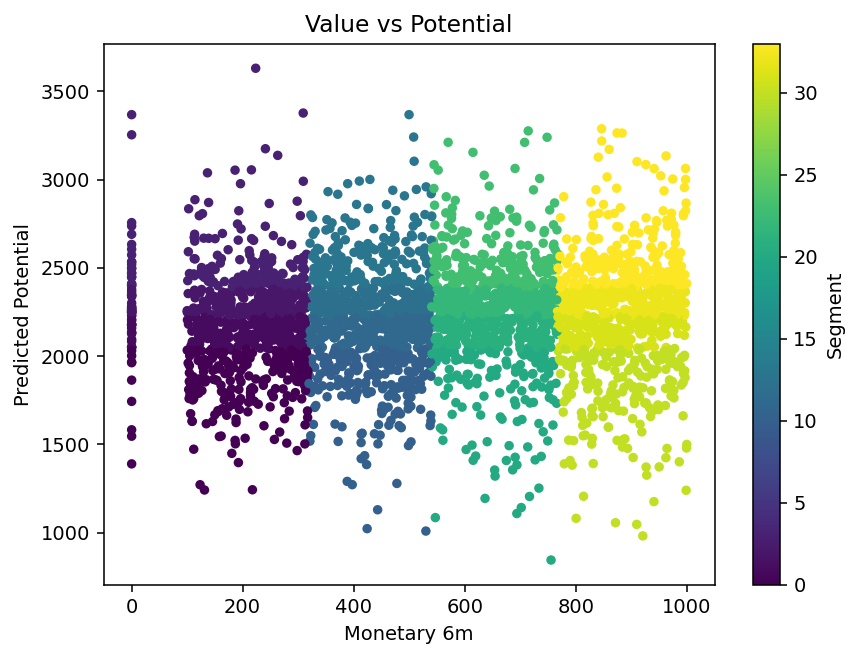


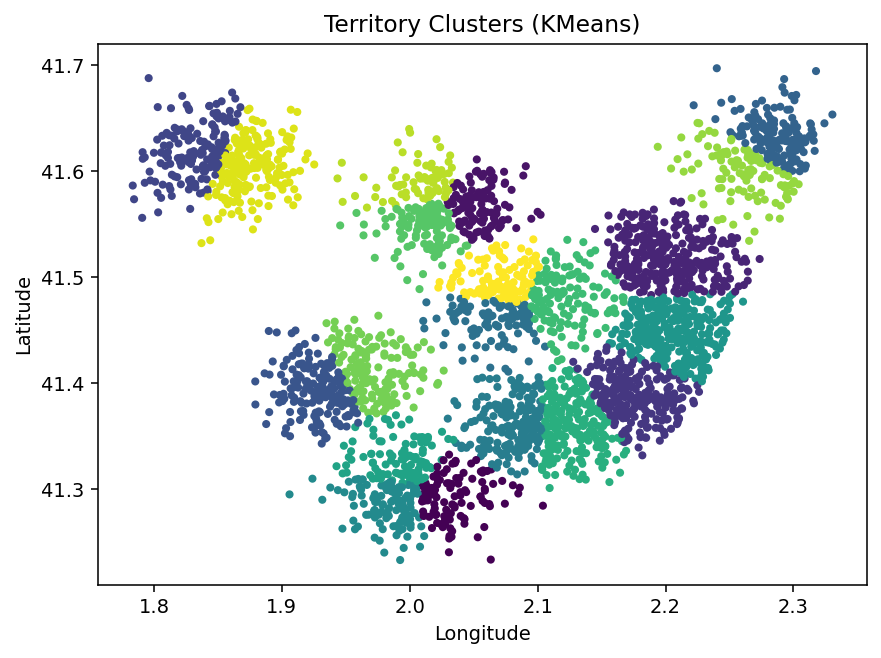


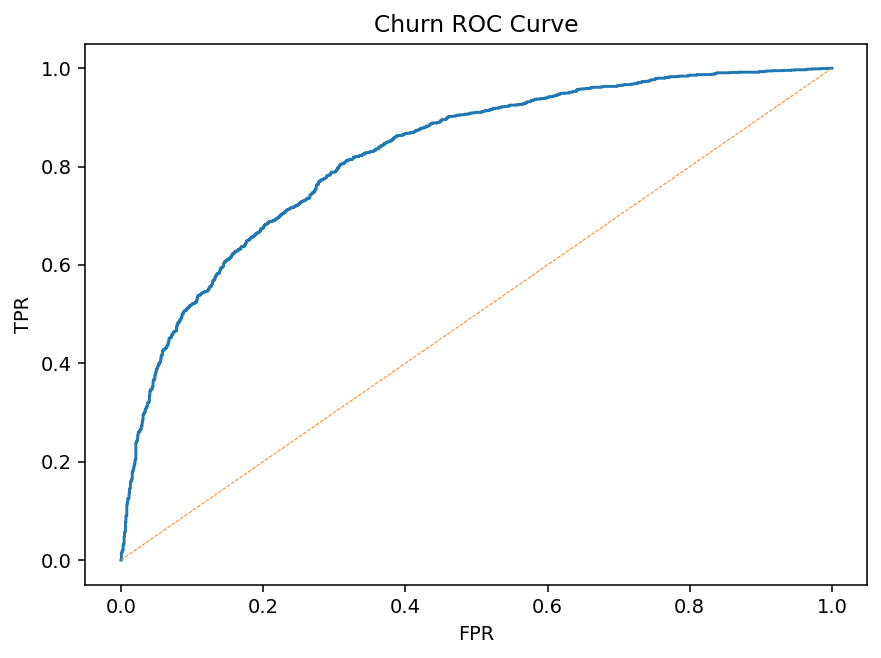


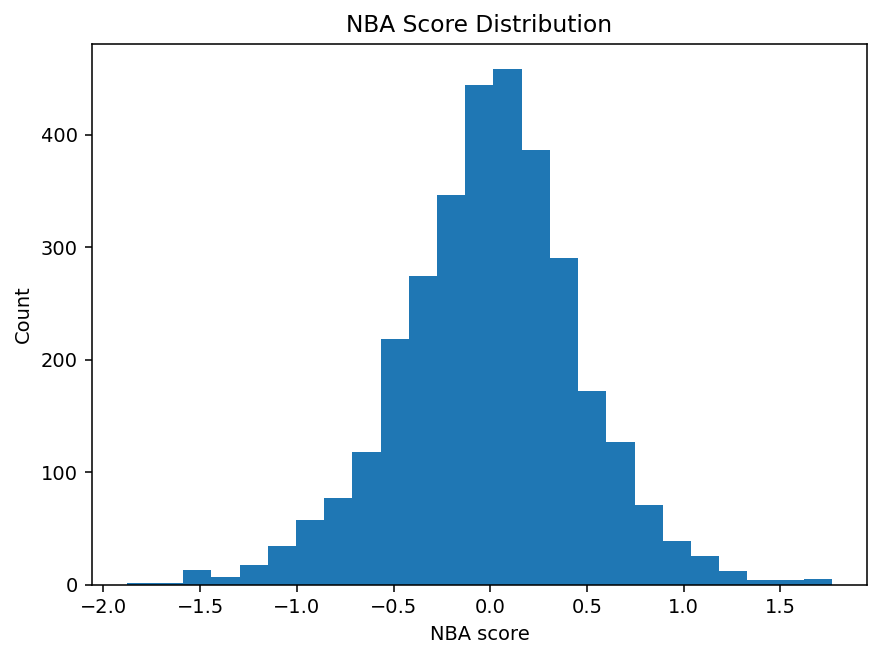


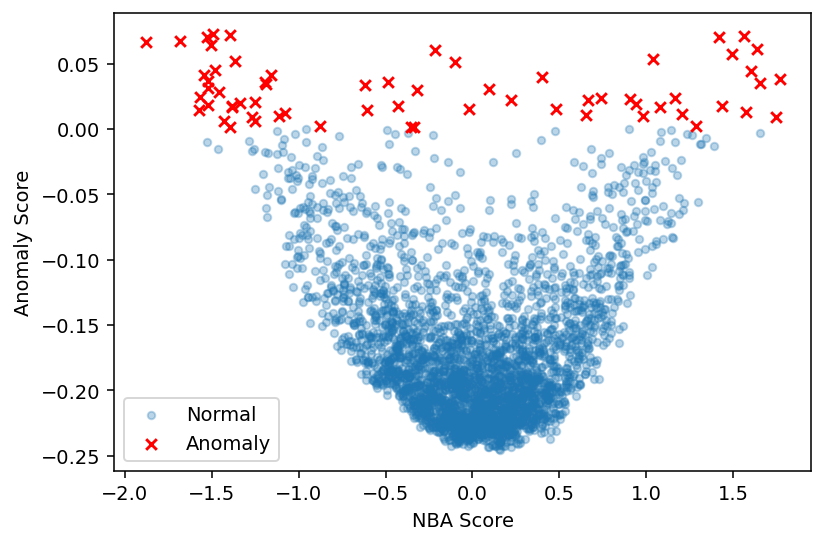


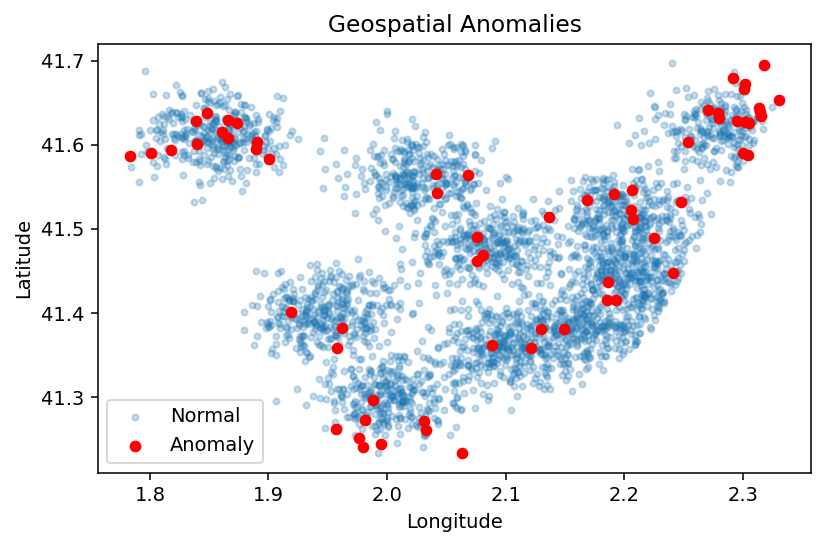

,stop,client_id,nba_score,recommended_channel,lat,lon
765,1,765,0.89,field,41.3354,2.0824
2996,2,2996,0.32,field,41.3375,2.0897
1736,3,1736,0.72,ecom_self,41.3546,2.0968
1732,4,1732,0.63,ecom_self,41.3588,2.0865
1107,5,1107,0.44,ecom_self,41.3556,2.0911
1060,6,1060,0.23,inbound_cc,41.3471,2.0983
3136,7,3136,0.43,ecom_self,41.3650,2.0601
63,8,63,-0.07,field,41.3788,2.0667
1657,9,1657,-0.24,ecom_self,41.3871,2.0603
1428,10,1428,-0.23,field,41.3767,2.0954



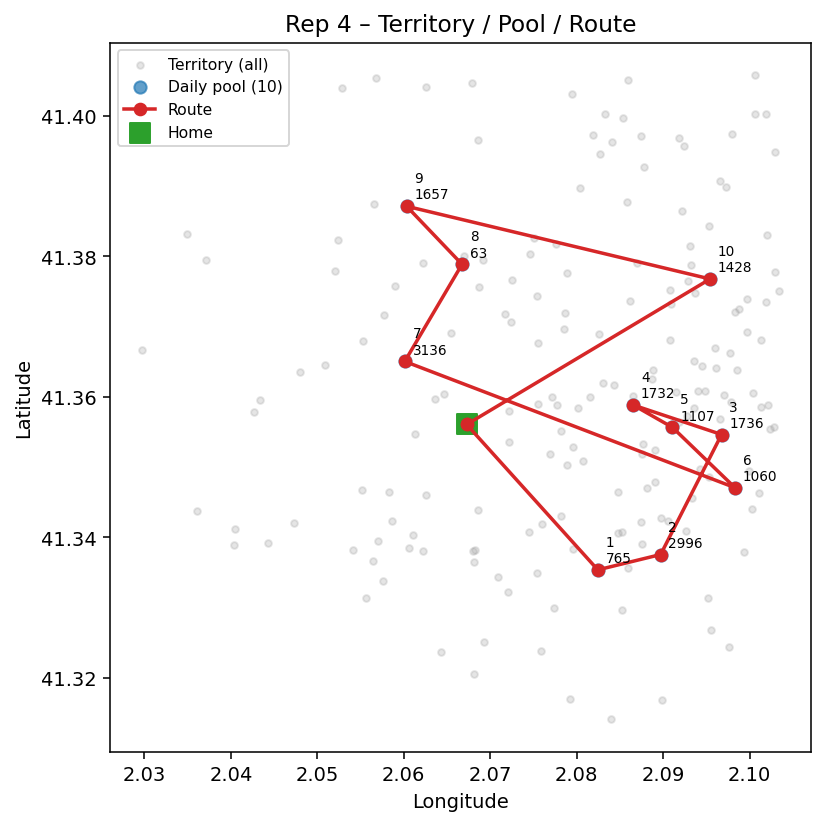

In [30]:
# Visual diagnostics
import io
import base64
from IPython.display import display, HTML

def _show_current_figure():
    fig = plt.gcf()
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=140, bbox_inches="tight")
    data = base64.b64encode(buf.getvalue()).decode("ascii")
    display(HTML(f'<img src="data:image/png;base64,{data}" style="max-width:100%; height:auto;"/>'))
    plt.close(fig)

_real_show = plt.show
plt.show = lambda *args, **kwargs: None
try:
    viz_segmentation(df)
    _show_current_figure()
    viz_territories(df)
    _show_current_figure()
    viz_roc(df)
    _show_current_figure()
    viz_nba_hist(df)
    _show_current_figure()
    viz_anomalies(df)
    _show_current_figure()
    viz_anomaly_map(df)
    _show_current_figure()
    viz_route(df, rep_id, order, pool)
    _show_current_figure()
finally:
    plt.show = _real_show


In [31]:
# Inline map render (satellite)
import base64

if fmap is None:
    print("Map not available. Run the map generation cell first.")
else:
    fmap_path = Path("route_map.html").resolve()
    fmap.save(fmap_path)
    print(f"Saved interactive map to {fmap_path.resolve()}")
    data = fmap_path.read_bytes()
    data_uri = "data:text/html;base64," + base64.b64encode(data).decode("ascii")
    display(IFrame(data_uri, width="100%", height=600))


Saved interactive map to /Users/macjcp/OptimAI/Sales-force-optimisation-AI-OR/route_map.html
